# Chlorophyll A data

## From Niskin bottles on CTD cast

Let's first load in some libraries that we are going to use today. If you are not sure whether you have the library installed, you can embed *install.packages* within an *if* statement, like this

In [1]:
if (!requireNamespace("RNetCDF", quietly = TRUE)) {
  install.packages("RNetCDF")
}
library(RNetCDF)
if (!requireNamespace("writexl", quietly = TRUE)) {
  install.packages("writexl")
}
library(writexl)

### One file

The data are available via a THREDDS server that you can find here:
https://opendap1.nodc.no/opendap/chemistry/point/cruise/nansen_legacy/

If you open the link above, you can navigate to different NetCDF files, and you will be linked to OPeNDAP data access forms like this one:
https://opendap1.nodc.no/opendap/chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_P1_NLEG01_20210430T023742.nc.html

OPeNDAP makes it possible to access data over the internet without you having to download the data to your computer first. You can just remove the *html* suffix from the URL above and include it in your R script in the same way that you might include some absolute filepath to a file on your computer. 

So now let's load the data into R for this cast.

In [2]:
url <- 'https://opendap1.nodc.no/opendap/chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_P1_NLEG01_20210430T035837.nc'
data <- open.nc(url)
print.nc(data)

netcdf classic {
dimensions:
	DEPTH = 7 ;
	maxStrlen64 = 64 ;
variables:
	NC_FLOAT DEPTH(DEPTH) ;
		NC_CHAR DEPTH:standard_name = "depth" ;
		NC_CHAR DEPTH:long_name = "Depth sampled below sea level, positive is increasing depth." ;
		NC_CHAR DEPTH:units = "m" ;
		NC_CHAR DEPTH:coverage_content_type = "coordinate" ;
		NC_CHAR DEPTH:positive = "down" ;
	NC_DOUBLE CHLOROPHYLL_A_TOTAL(DEPTH) ;
		NC_DOUBLE CHLOROPHYLL_A_TOTAL:_FillValue = 1e+32 ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:standard_name = "mass_concentration_of_chlorophyll_a_in_sea_water" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:long_name = "Mass concentration of Chlorophyll A in sea water, after acid correction" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:units = "μg L-1" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:ancillary_variables = "FILTERED_VOL_TOTAL, EVENTID_TOTAL" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:coverage_content_type = "physicalMeasurement" ;
	NC_DOUBLE PHAEOPIGMENTS_TOTAL(DEPTH) ;
		NC_DOUBLE PHAEOPIGMENTS_TOTAL:_FillValue = 1e+32 ;
		NC_CHAR PHAEOPIGMENTS_TO

The data have a single dimension, pressure. For the profile I have chosen above, there are 82 data points for each variable.

Now let's access a few of the variables.

In [3]:
depth <- var.get.nc(data,'DEPTH')
chla_total <- var.get.nc(data,'CHLOROPHYLL_A_TOTAL')
chla_10um <- var.get.nc(data,'CHLOROPHYLL_A_10um')

Let's make a basic plot.

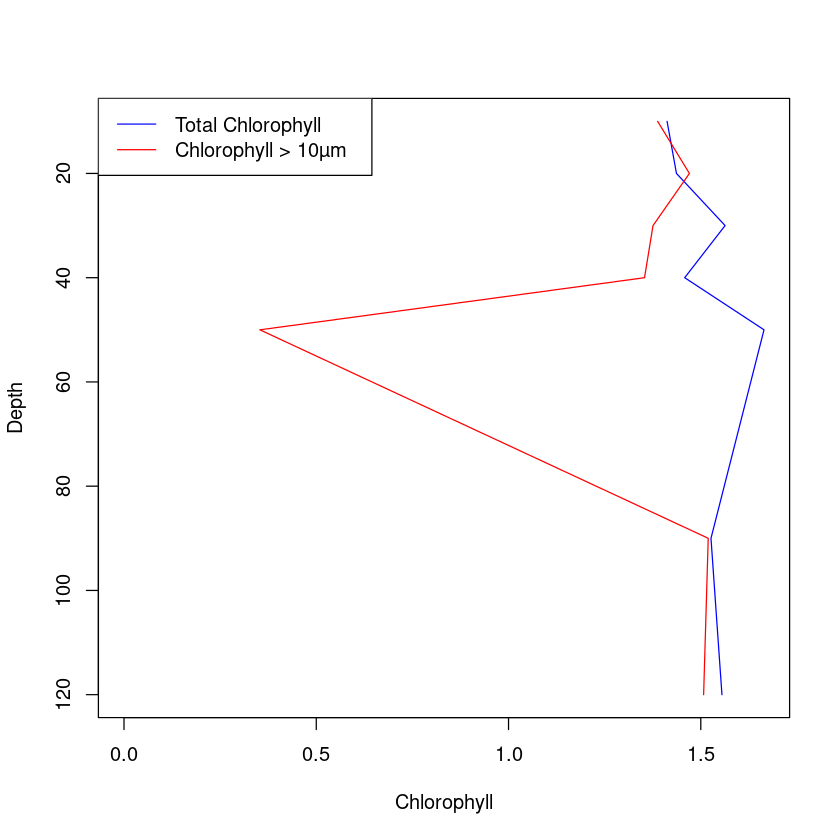

In [4]:
# Plot the first dataset with depth on the y-axis
plot(
    chla_total,
    depth,
    type = "l",
    col = "blue",      # Choose a color for the first line
    ylab = "Depth",    # Label for the y-axis
    xlab = "Chlorophyll", # Label for the x-axis
    xlim = c(0,max(chla_total)),
    ylim = (rev(range(depth))) # Reverse the y-axis to make depth increase downwards
)

# Add the second dataset to the existing plot
lines(
    chla_10um,
    depth,
    col = "red"        # Choose a different color for the second line
)

# Add a legend to distinguish the lines
legend(
    "topleft",       # Position of the legend
    legend = c("Total Chlorophyll", "Chlorophyll > 10µm"),
    col = c("blue", "red"), # Colors corresponding to the lines
    lty = 1           # Line type
)

Now let's write the data to a dataframe that.

In [5]:
df <- data.frame(Depth = depth, Chlorophyll_A_total = chla_total, Chlorophyll_A_10um = chla_10um)

We can write that out to a CSV file or XLSX file if we like.

In [6]:
# Write to CSV
write.csv(df, "../data/chlrophyll_a_data_one_cast.csv", row.names = FALSE)

# Write to XLSX using writexl
write_xlsx(df, "../data/chlrophyll_a_data_one_cast.xlsx")

### Looping through multiple files

What if we want to loop through and access all the casts from, for example, a single cruise?

We can think of this as the human interface:
https://opendap1.nodc.no/opendap/chemistry/point/cruise/nansen_legacy/2021704/contents.html

And this as the machine interface:
https://opendap1.nodc.no/opendap/chemistry/point/cruise/nansen_legacy/2021704/catalog.xml

If you have never looked at an XML file like this before, don't worry. What we want to do is access the URL paths of each file and dump them to a list that we can loop through. We need to install another package first.

In [7]:
if (!requireNamespace("xml2", quietly = TRUE)) {
  install.packages("xml2")
}
library(xml2)

Now let's make a list of the OPeNDAP URLs for each file.

In [8]:
# Read the XML file
xml_url <- 'https://opendap1.nodc.no/opendap/chemistry/point/cruise/nansen_legacy/2021704/catalog.xml'
xml_content <- read_xml(xml_url)

# Extract all <thredds:access> nodes with serviceName="dap"
dap_nodes <- xml_find_all(xml_content, ".//thredds:access[@serviceName='dap']", ns = xml_ns(xml_content))

# Extract the URLs
dap_urls <- xml_attr(dap_nodes, "urlPath")

# Base URL
base_url <- "https://opendap1.nodc.no/opendap/"

# Combine base URL with URL paths to get full URLs
full_urls <- paste0(base_url, dap_urls)

# Print the full URLs
print(full_urls)

 [1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG02_20210501T133217.nc"                               
 [2] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG02_20210501T141507.nc"                               
 [3] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG05_20210503T043651.nc"                               
 [4] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG05_20210503T045538.nc"                               
 [5] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_statio

Now we need to use a for loop to access each file in turn. Here is a quick example of how a for loop works if you are not familiar.

In [9]:
animals <- c('pig', 'dog', 'horse')

for (animal in animals) {
    message <- paste('Hello there,',animal)
    print(message)
}

[1] "Hello there, pig"
[1] "Hello there, dog"
[1] "Hello there, horse"


Now a more relevant example

In [10]:
for (url in full_urls) {
    print(url)   
}

[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG02_20210501T133217.nc"
[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG02_20210501T141507.nc"
[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG05_20210503T043651.nc"
[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG05_20210503T045538.nc"
[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEGA_20210516T181751.nc"
[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and

We want to access only the data from the Niskin bottles on the CTD casts. So we need to exclude some files.

In [11]:
exclude <- c('ice_core', 'slurp_gun', 'under_ice_water')

# Function to check if a filename contains any of the excluded substrings
contains_excluded_substring <- function(filename, exclude_list) {
  any(sapply(exclude_list, function(ex) grepl(ex, filename)))
}

for (url in full_urls) {
    filename <- basename(url) # Extract the filename
    
    # Check if the filename contains any excluded substrings
    if (!contains_excluded_substring(filename, exclude)) {
        print(url)  # Print the URL if it does not contain excluded substrings
    }
}

[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG02_20210501T133217.nc"
[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG02_20210501T141507.nc"
[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG05_20210503T043651.nc"
[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEG05_20210503T045538.nc"
[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_NLEGA_20210516T181751.nc"
[1] "https://opendap1.nodc.no/opendap//chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and

Some variables are present in some files and not others. So perhaps we just want to load in all the variables, regardless of their names, and dump the data to a CSV file. Let's try that.

In [13]:
exclude <- c('ice_core', 'slurp_gun', 'under_ice_water')

# Function to check if a filename contains any of the excluded substrings
contains_excluded_substring <- function(filename, exclude_list) {
  any(sapply(exclude_list, function(ex) grepl(ex, filename)))
}

for (url in full_urls) {
    filename <- basename(url) # Extract the filename
    
    # Check if the filename contains any excluded substrings
    if (!contains_excluded_substring(filename, exclude)) {
        csv_filename <- sub("\\.nc$", ".csv", filename) # Replace .nc extension with .csv
        
        # Open the file
        data <- open.nc(url)

        # Get the number of variables in the file
        nvars <- as.integer(file.inq.nc(data)['nvars'])

        # Initialize an empty list to store the data
        data_list <- list()

        # Loop through each variable, retrieve the data, and store it in the list
        for (var in 1:nvars) {
          idx <- var - 1 # Getting the index of the variable. Count starts at 0
          var_name <- var.inq.nc(data,idx)$name
          data_list[[var_name]] <- var.get.nc(data, idx)
        }

        # Convert the list to a dataframe and save it as a CSV file
        df <- as.data.frame(data_list)
        # write.csv(df, paste0("../data/", csv_filename), row.names = FALSE)        
    }
}



## Ice core data

In [21]:
url <- 'https://opendap1.nodc.no/opendap/chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_P4_NLEG11_Ice_20210505T064610Z_ice_core.nc'
data <- open.nc(url)
print.nc(data)

netcdf classic {
dimensions:
	DEPTH = 4 ;
	maxStrlen64 = 64 ;
variables:
	NC_DOUBLE CHLOROPHYLL_A_TOTAL(DEPTH) ;
		NC_DOUBLE CHLOROPHYLL_A_TOTAL:_FillValue = 1e+32 ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:standard_name = "mass_concentration_of_chlorophyll_a_in_sea_ice" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:long_name = "Total mass concentration of Chlorophyll A in sea ice core, after acid correction" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:units = "μg L-1" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:ancillary_variables = "FILTERED_VOL_TOTAL, EVENTID_TOTAL" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:coverage_content_type = "physicalMeasurement" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:coordinates = "MAXIMUM_DEPTH MINIMUM_DEPTH" ;
	NC_DOUBLE PHAEOPIGMENTS_TOTAL(DEPTH) ;
		NC_DOUBLE PHAEOPIGMENTS_TOTAL:_FillValue = 1e+32 ;
		NC_CHAR PHAEOPIGMENTS_TOTAL:standard_name = "mass_concentration_of_phaeopigments_in_sea_ice" ;
		NC_CHAR PHAEOPIGMENTS_TOTAL:long_name = "Total mass concentration of phaeopigment in sea ice core, after acid correction" ;
	

In these data, you can see that the data variables again have a *DEPTH* dimension. However, each value is representative of a cell - a depth range for each chunk of the ice core that has been melted down.

So the file also includes *MINIMUM_DEPTH* and *MAXIMUM_DEPTH* variables to show this range.

This is actually not the best, most CF-compliant way to do this. These data are human-readable, but do not follow the recommend best practices. I should have used bounds instead when creating the files. You can read about cell bounds here.
https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#_data_representative_of_cells

Following the best practices is important as it encourages consistency between datasets and makes it easier for someone to build a service that works on not just one file but all similar files. I will cover how to encode data representative of cells in my tutorial series on working with NetCDF files in R, which is linked here. At the time of writing, this is not complete:
https://lhmarsden.github.io/NetCDF_in_R_from_beginner_to_pro/intro.html

You can access the data in the same way you would the data from the Niskin bottles.

In [24]:
min_depth <- var.get.nc(data,'MINIMUM_DEPTH')
max_depth <- var.get.nc(data,'MAXIMUM_DEPTH')
chla_total <- var.get.nc(data,'CHLOROPHYLL_A_TOTAL')
chla_10um <- var.get.nc(data,'CHLOROPHYLL_A_10um')

df <- data.frame(
    Min_depth = min_depth, 
    Max_depth = max_depth,
    Chlorophyll_A_total = chla_total, 
    Chlorophyll_A_10um = chla_10um
)

df

Min_depth,Max_depth,Chlorophyll_A_total,Chlorophyll_A_10um
<dbl>,<dbl>,<dbl>,<dbl>
0,3,181.030451,138.751091
3,10,4.538515,3.046370
10,20,14.572600,1.118798
20,NaN,2.303262,1.490862


## Under ice water

In [25]:
url <- 'https://opendap1.nodc.no:443/opendap/chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_P6_NLEG21_NPAL15_Ice_20210509T133528Z_under_ice_water.nc'
data <- open.nc(url)
print.nc(data)

netcdf classic {
dimensions:
	DEPTH = 1 ;
	maxStrlen64 = 64 ;
variables:
	NC_FLOAT DEPTH(DEPTH) ;
		NC_CHAR DEPTH:standard_name = "depth" ;
		NC_CHAR DEPTH:long_name = "Depth sampled below sea level, positive is increasing depth." ;
		NC_CHAR DEPTH:units = "m" ;
		NC_CHAR DEPTH:coverage_content_type = "coordinate" ;
		NC_CHAR DEPTH:positive = "down" ;
	NC_DOUBLE CHLOROPHYLL_A_TOTAL(DEPTH) ;
		NC_DOUBLE CHLOROPHYLL_A_TOTAL:_FillValue = 1e+32 ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:standard_name = "mass_concentration_of_chlorophyll_a_in_sea_water" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:long_name = "Mass concentration of Chlorophyll A in under ice sea water, after acid correction" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:units = "μg L-1" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:ancillary_variables = "FILTERED_VOL_TOTAL, EVENTID_TOTAL" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:coverage_content_type = "physicalMeasurement" ;
	NC_DOUBLE PHAEOPIGMENTS_TOTAL(DEPTH) ;
		NC_DOUBLE PHAEOPIGMENTS_TOTAL:_FillValue = 1e+32 ;
		NC_CHAR PHAEOP

The under ice water files are structured in the same was as the files for the Niskins from the CTD casts. The only difference is that most of these files have only 1 or 2 data points.

## Melt ponds

For these data, I have used a dimension *MELTPOND_NUMBER* to number each of the meltponds sampled. So if multiple meltponds were sampled, each data point for each variable would be from a different meltpond.

In [27]:
url <- 'https://opendap1.nodc.no:443/opendap/chemistry/point/cruise/nansen_legacy/2021708/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021708_station_P6_NLEG21_NPAL15_Ice_20210722T061551Z_meltponds.nc'
data <- open.nc(url)
print.nc(data)

netcdf classic {
dimensions:
	MELTPOND_NUMBER = 1 ;
	maxStrlen64 = 64 ;
variables:
	NC_INT MELTPOND_NUMBER(MELTPOND_NUMBER) ;
		NC_CHAR MELTPOND_NUMBER:long_name = "Arbitrary number assigned of the meltpond sampled. Each number represents a different melt pond that was sampled at the ice station." ;
		NC_CHAR MELTPOND_NUMBER:coverage_content_type = "referenceInformation" ;
	NC_DOUBLE CHLOROPHYLL_A_TOTAL(MELTPOND_NUMBER) ;
		NC_DOUBLE CHLOROPHYLL_A_TOTAL:_FillValue = 1e+32 ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:standard_name = "mass_concentration_of_chlorophyll_a_in_sea_water" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:long_name = "Mass concentration of Chlorophyll A in melt pond, after acid correction" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:units = "μg L-1" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:ancillary_variables = "FILTERED_VOL_TOTAL, EVENTID_TOTAL" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:coverage_content_type = "physicalMeasurement" ;
	NC_DOUBLE PHAEOPIGMENTS_TOTAL(MELTPOND_NUMBER) ;
		NC_DOUBLE PHAEOPIGMENTS_TOTAL:_Fill

## Slurp guns

For these data, multiple samples were taken at the same point. Therefore, I have used *SAMPLE_NUMBER* as a dimension for all of the variables.

In [26]:
url <- 'https://opendap1.nodc.no:443/opendap/chemistry/point/cruise/nansen_legacy/2021704/Chlorophyll_A_and_phaeopigments_Nansen_Legacy_cruise_2021704_station_P6_NLEG21_NPAL15_Ice_20210511T073146Z_slurp_gun.nc'
data <- open.nc(url)
print.nc(data)

netcdf classic {
dimensions:
	SAMPLE_NUMBER = 8 ;
	maxStrlen64 = 64 ;
variables:
	NC_INT SAMPLE_NUMBER(SAMPLE_NUMBER) ;
		NC_CHAR SAMPLE_NUMBER:long_name = "Sequential counter for sample taken using a slurp gun at the station" ;
	NC_CHAR EVENTREMARKS(maxStrlen64, SAMPLE_NUMBER) ;
		NC_CHAR EVENTREMARKS:long_name = "Descriptive remarks about the sample and location sampled" ;
		NC_CHAR EVENTREMARKS:coverage_content_type = "referenceInformation" ;
	NC_DOUBLE CHLOROPHYLL_A_TOTAL(SAMPLE_NUMBER) ;
		NC_DOUBLE CHLOROPHYLL_A_TOTAL:_FillValue = 1e+32 ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:standard_name = "mass_concentration_of_chlorophyll_a_in_sea_water" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:long_name = "Mass concentration of Chlorophyll A in sea water, after acid correction" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:units = "μg L-1" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:ancillary_variables = "FILTERED_VOL_TOTAL, EVENTID_TOTAL" ;
		NC_CHAR CHLOROPHYLL_A_TOTAL:coverage_content_type = "physicalMeasurement" ;
	NC_DOUBLE PHAE

## Citing the data

Parent-child relationships have been used in this data publication. Here is the landing page for all the data from all cruises.
https://doi.org/10.21335/NMDC-1371694848

This is the recommended citation if you use all of the data or data from many different cruises.

*Anna Vader (2022) Chlorophyll A and phaeopigments Nansen Legacy https://doi.org/10.21335/NMDC-1371694848*

You can navigate to different *parts* and there is one part per cruise on the landing page. There is one citation per cruise that you can use if you cite if you are using data only from one cruise. For example

*Anna Vader, Lucie Goraguer, Luke Marsden (2022) Chlorophyll A and phaeopigments Nansen Legacy cruise 2021708 https://doi.org/10.21335/NMDC-1248407516*

You can also navigate further to one part per cast. You can cite one of a couple of casts if these are the only data you have used in this collection. For example

*Anna Vader, Lucie Goraguer, Luke Marsden (2022) Chlorophyll A and phaeopigments Nansen Legacy cruise 2021708 station P1 (NLEG01) 2021-07-14T08:15:29 https://doi.org/10.21335/NMDC-1248407516-P1(NLEG01)*